In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from time import strptime
import datetime
from datetime import datetime
import warnings
import time
import csv
import glob
import logging
import importlib
from tqdm import tqdm
import json
import networkx as nx
import seaborn as sns
import re
from operator import itemgetter
import matplotlib as mpl 
import matplotlib.cm as mcm
import community
from community import community_louvain as cm
import leidenalg as la
import igraph as ig
from cdlib import algorithms
import sys
sys.path.append('C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/notebook/tweet_utils')
import tweets_utils
warnings.filterwarnings('ignore')
path = "F:/Supsi/COVID-19-Tweets/large_files/rt_network/"
%autosave 3600

Autosaving every 3600 seconds


# Indice

- [Functions](#func)

- [Big Network](#big)

- [Community 1](#com_1)

# Functions
<a id="func"/>

In [2]:
def network_general(df, col_1="name", col_2="rt_name"):
    retweets_graph = nx.from_pandas_edgelist(df, col_1 ,col_2 , create_using=nx.DiGraph())
    info = nx.info(retweets_graph)
    
    degree_dict = dict(retweets_graph.degree(retweets_graph.nodes()))
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    
    in_degree_dict = dict(retweets_graph.in_degree(retweets_graph.nodes()))
    sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)
    
    out_degree_dict = dict(retweets_graph.out_degree(retweets_graph.nodes()))
    sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)
    
    return {"info": info, "degree": sorted_degree, "in_degree": sorted_in_degree,  
            "out_degree": sorted_out_degree}

In [3]:
def network_louvain(df, col_1="name", col_2="rt_name"):
    retweets_graph_und = nx.from_pandas_edgelist(df, col_1, col_2)
    info = nx.info(retweets_graph_und)
    
    best_part = cm.best_partition(retweets_graph_und, random_state=42)
    
    return {"info": info, "best_part": best_part}

In [4]:
def rt_community(df, louvain, col="user_screen_name"):
    community = []
    name = []
    rt = []
    for i in df[col]:
        if i in louvain:
            rt.append((i, louvain.get(i)))
    for i in range(len(rt)):
        community.append(rt[i][1])
    val = pd.Series(community)
    val = val.value_counts().sort_values(ascending=False)
    return val

In [33]:
def plot_hist(val, title, col="lightseagreen"):
    fig = plt.figure()
    ax = val[:10].plot(kind='barh', color=col) #orange #lightseagreen
    ax.set_title(title, fontsize=15)
    ax.invert_yaxis()
    plt.show()

In [34]:
def df_from_degree(degree, lst_subcomm, community, subcomm):
    lst_name = []
    lst_deg = []
    lst_comm = []
    lst_descr = []
    lst_sub = []
    cont = 0
    for i in degree: #primi 50 8
        if cont == 5:
            break
        if i[0] in lst_subcomm:
            cont = cont + 1
            lst_name.append(i[0])
            lst_deg.append(i[1])
            lst_comm.append(community)
            lst_sub.append(subcomm)
    df = pd.DataFrame(list(zip(lst_name, lst_deg, lst_comm, lst_sub)),
                   columns =['name', 'degree', 'community', "subcommunity"])
    return df

In [39]:
def plot_all_nt_info(leiden, good_rt_flt, ccdh_rt_flt, name_community):
    communities = []
    for i in leiden:
        communities.append(leiden.get(i))
    comm = pd.Series(communities).value_counts().sort_values(ascending=False)
    print(len(comm))
    ax = comm[:15].plot(kind='barh', color='plum') #orange #lightseagreen
    ax.set_title(f'Number of nodes per community - {name_community} (top 15)', fontsize=15)
    ax.invert_yaxis()
    plt.show()
    s = 0
    for i in comm[:5]:
        s = s + i 
    print(f"le prime 5 subcommunities sono il {round(s/comm.sum()*100,2)}% del totale nella {name_community}")
    print(f"il numero di utenti è {comm.sum()}")
    val2 = rt_community(good_rt_flt, leiden, "screen_name")
    val = rt_community(ccdh_rt_flt, leiden)
    tweets_utils.plot_two_hist(val2[:10], val[:10], "Follower of Dozen")

In [8]:
def generate_csv(lst, output_filename):
    rt = pd.read_csv("F:/Supsi/COVID-19-Tweets/large_files/rt_network/names/user_rtuser.csv",
                lineterminator="\n", low_memory=False)
    df = pd.DataFrame(lst, columns=["name_0"])
    merge_name = rt.merge(df, left_on="name", right_on="name_0", how="left")
    df = pd.DataFrame(lst, columns=["rt_name_0"])
    merge_name = merge_name.merge(df, left_on="rt_name", right_on="rt_name_0", how="left")
    subcomm_0 = merge_name[merge_name["name_0"].notna() & merge_name["rt_name_0"].notna()][["name_0", "rt_name_0"]]
    subcomm_0 = subcomm_0.reset_index(drop=True)
    subcomm_0.rename(columns={'name_0': 'name', 'rt_name_0': 'rt_name'}, inplace=True)
    subcomm_0.to_csv(f"C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/{output_filename}.csv",
                    line_terminator="\n", encoding="utf-8", index=False)

### Load Files

In [9]:
def read_from_json(path):
    start_time = time.perf_counter()
    file = open (path,)
    obj = json.loads(file.read())
    file.close()
    stop_time = time.perf_counter()
    print("Time: ",stop_time-start_time)
    return obj

In [10]:
path_ccdh_rt = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/ccdh/")
ccdh_rt = pd.read_csv(path_ccdh_rt[0] + "rt_bad.csv")
good_rt = pd.read_csv(path_ccdh_rt[0] + "rt_good.csv")
path_dozen = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/")
bad_dozen = pd.read_csv(path_dozen[0] + "disinformation_users.csv")
good_dozen = pd.read_csv(path_dozen[0] + "all_good_users.csv")
files_tweets = glob.glob("F:/Supsi/COVID-19-Tweets/*/tweets.csv")

# Big Network
<a id="big"/>

In [11]:
path_inside = path + "/leiden/big/"
leiden_path = glob.glob(path_inside + "best*.json")[0]
leiden = read_from_json(leiden_path)
deg_path = glob.glob(path_inside + "degree.json")[0]
degree = read_from_json(deg_path)
ccdh_rt_flt = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in leiden])]
good_rt_flt = good_rt[good_rt.screen_name.isin([x for x in leiden])]

Time:  35.09305549999999
Time:  27.263690999999994


322797


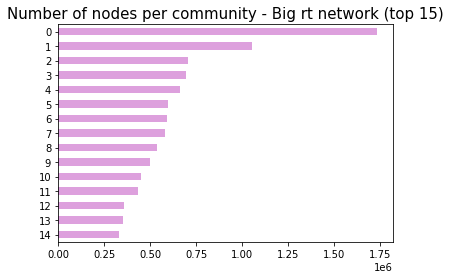

le prime 5 subcommunities sono il 38.78% del totale nella Big rt network
il numero di utenti è 12513502


In [40]:
plot_all_nt_info(leiden, good_rt_flt, ccdh_rt_flt, "Big rt network")

In [30]:
lst = []
for i in leiden:
    if leiden.get(i) == 12:
        lst.append(i)
count  = 0
for i in degree:
    if i[0] in lst:
        print(i)
        count = count + 1
        if count == 20:
            break

['charliekirk11', 49985]
['RealJamesWoods', 40785]
['RealCandaceO', 27123]
['IngrahamAngle', 24224]
['DonaldJTrumpJr', 23569]
['GOPLeader', 21612]
['JackPosobiec', 21166]
['RyanAFournier', 19368]
['PrisonPlanet', 17758]
['ClayTravis', 16250]
['WhiteHouse45', 15802]
['bennyjohnson', 13458]
['brithume', 13434]
['TomFitton', 13332]
['catturd2', 11996]
['marklevinshow', 11885]
['SecPompeo', 11865]
['GOP', 11835]
['TrumpWarRoom', 11718]
['jsolomonReports', 11443]


Comm 0: Users en

Comm 1: CNN, BarackObama, tedlieu, nytimes, funder USA DEM

Comm 2: JPN

Comm 3: UK

Comm 4: INDIA

Comm 5: ESP

Comm 6: BRA

Comm 7: KOR

Comm 8: AFR

Comm 9: ESP (Sudamerica)

Comm 10: Reuters, cnni, business, Quicktake, BBCWorld, NEWS

Comm 11: FRA

Comm 12: USA REPUBLICAN


In [28]:
for i in degree[:120]:
    if i[0] in lst_12:
        print(i)

['charliekirk11', 49985]
['RealJamesWoods', 40785]
['RealCandaceO', 27123]
['IngrahamAngle', 24224]
['DonaldJTrumpJr', 23569]
['GOPLeader', 21612]
['JackPosobiec', 21166]
['RyanAFournier', 19368]


#### Dozen inside

BAD:

unhealthytruth, BusyDrT, RobertKennedyJr, mercola, 
kevdjenkins1, DrChrisNorthrup, DrButtar -->12

GOOD:

103 nella 1, 85 nella 10, 26 nella 18, 3 nella 8

# Community 1
<a id="com_1"/>

<p>
    
    CNN, BarackObama, tedlieu, nytimes, funder, JoeBiden, maddow, kylegriffin1
    
</p>

In [41]:
path_inside = path + "/leiden/network_1/"
leiden_path = glob.glob(path_inside + "leiden*.json")[0]
leiden = read_from_json(leiden_path)
deg_path = glob.glob(path_inside + "degree.json")[0]
degree = read_from_json(deg_path)
ccdh_rt_flt_1 = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in leiden])]
good_rt_flt_1 = good_rt[good_rt.screen_name.isin([x for x in leiden])]

Time:  1.4193026000002646
Time:  1.7410131000006004


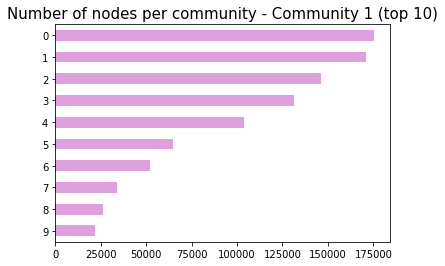

le prime 5 subcommunities sono il 69.12% del totale nella Community 1
il numero di utenti è 1052804


In [42]:
plot_all_nt_info(leiden, good_rt_flt_1, ccdh_rt_flt_1, "Community 1")

# Community 12
<a id="com_12"/>

<p>

    Community 2-0 Louvain:
    charliekirk11, RealJamesWoods, RealCandaceO, IngrahamAngle, DonaldJTrumpJr
    Community 12 Leiden:
    charliekirk11, RealJamesWoods, RealCandaceO, IngrahamAngle, DonaldJTrumpJr

</p>

In [47]:
path_inside = path + "/leiden/network_12/"
leiden_path = glob.glob(path_inside + "leiden*.json")[0]
leiden_12 = read_from_json(leiden_path)
deg_path = glob.glob(path_inside + "degree.json")[0]
degree_12 = read_from_json(deg_path)
ccdh_rt_flt_12 = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in leiden_12])]
good_rt_flt_12 = good_rt[good_rt.screen_name.isin([x for x in leiden_12])]

Time:  0.8343866999994134
Time:  1.0300659000004089


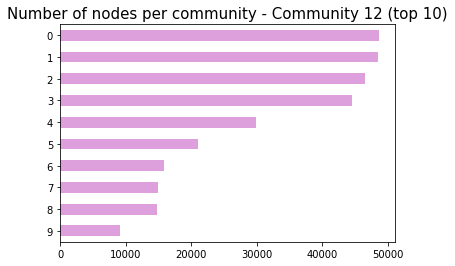

le prime 5 subcommunities sono il 61.24% del totale nella Community 12
il numero di utenti è 356467


In [48]:
plot_all_nt_info(leiden_12, good_rt_flt_12, ccdh_rt_flt_12, "Community 12")

<p>
    
    Community 12-3: influencer
    RealJamesWoods, catturd2, ChuckCallesto, atensnut, RealMattCouch, WayneDupreeShow, Thomas1774Paine, TimRunsHisMouth, DavidJHarrisJr
    Community 12-5: information
    Bad Dozen, officialmcafee, Kevin_Shipp, LionelMedia, Perpetualmaniac, HighWireTalk, BusyDrT, LegendaryEnergy, delbigtree
    Community 12-1: cons
    IngrahamAngle, DonaldJTrumpJr, GOPLeader, TomFitton, WhiteHouse45, marklevinshow, TrumpWarRoom, jsolomonReports
    Community 12-0: journals
    benshapiro, MattWalshBlog, AlexBerenson, JordanSchachtel, RandPaul, TheBabylonBee, stillgray, Timcast, CalebJHull


</p>

In [66]:
lst_3 = []
lst_5 = []
lst_1 = []
lst_0 = []
lst_2 = []
for i in leiden_12:
    if leiden_12.get(i) == 3:
        lst_3.append(i)
    if leiden_12.get(i) == 5:
        lst_5.append(i)
    if leiden_12.get(i) == 1:
        lst_1.append(i)
    if leiden_12.get(i) == 0:
        lst_0.append(i)
    if leiden_12.get(i) == 2:
        lst_2.append(i)

In [64]:
for i in lst_5:
    if i in list(bad_dozen["screen_name"]):
        print(i)

unhealthytruth
BusyDrT
RobertKennedyJr
mercola
kevdjenkins1
DrButtar
DrChrisNorthrup


In [65]:
for i in lst_3:
    if i in list(bad_dozen["screen_name"]):
        print(i)

In [70]:
for i in degree_12[:100]:
    if i[0] in lst_0:
        print(i)

['benshapiro', 9332]
['MattWalshBlog', 4522]
['AlexBerenson', 4254]
['JordanSchachtel', 4083]
['RandPaul', 3851]
['TheBabylonBee', 3742]
['stillgray', 3661]
['Timcast', 3661]
['CalebJHull', 3508]
['DanCrenshawTX', 3498]
['DLoesch', 3252]
['redsteeze', 3160]


# Dangerous sources

- @LionelMedia: https://www.axios.com/qanon-conspiracy-theorist-lionel-oval-office-trump-f3fa2c71-2136-4aa7-b7b4-c9eb10bb43d8.html
- @Kevin_Shipp: https://www.thedailybeast.com/i-got-trained-by-a-cia-officer-and-qanon-movie-star
- @officialmcafee: https://www.tampabay.com/news/nation-world/2021/06/29/rumors-surrounding-john-mcafees-death-linked-to-qanon-conspiracy/ - https://www.businessinsider.com/john-mcafee-death-suicide-qanon-jeffrey-epstein-conspiracy-theories-2021-6?r=US&IR=T
- @AlexBerenson: https://www.haaretz.com/israel-news/alex-berenson-banned-from-twitter-after-spreading-false-info-on-israeli-vaccines-1.10162481 - from hero to zero
- @RandPaul: https://eu.courier-journal.com/story/opinion/2021/09/22/mcconnell-and-pauls-kentucky-steeped-in-radical-conspiracy-theories/8373067002/
- @TheBabylonBee: Fake news e satira